# Отток клиентов

# 1. Подготовка данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

Посмотрим на данные:

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные нуждаются в подготовке, прежде чем использовать их для обучения моделей. Не получится обучить модели с категориальными признаками, нужно преобразовать их в численные. Также удалим лишние признаки от которых не зависит отток клиентов (фамилия) и выполним поиск дупликатов.<br>
Воспользуемся техникой прямого кодирования (OHE), т.к. она более универсальна и посмотрим на результаты:

In [4]:
data = data.drop(['RowNumber', 'Surname'], axis=1)

In [5]:
print('Количество дубликатов клиентов:', data['CustomerId'].duplicated().sum())

Количество дубликатов клиентов: 0


Т.к. дубликаты клиентов отсутствуют, то признак идентификатора также можно удалить

In [6]:
data = data.drop('CustomerId', axis=1)

In [7]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Данные успешно преобразованы, но имеются пропуски у признака *Tenure* (количество недвижимости у клиента) у 909 объектов. 

Рассмотрим подробнее этот признак:

In [8]:
print('Среднее значение количества недвижимости = {:.2}, медианное = {:.2}'.format(
    data['Tenure'].mean(), data['Tenure'].median()))

Среднее значение количества недвижимости = 5.0, медианное = 5.0


Среднее значение и медиана равны. Заполним ими пропуски:


*(я пытался сделать модель, но R2 было около нуля, так что..)*

In [9]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null float64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Разделим выборку на признаки и целевые признаки.<br>
Т.к. у нас не имеется тестовой выборки, разобъем данные на 3 выборки - тренировочную, тестовую и валидационную. Воспользуемся стандартным соотношением 3:1:1 <br>


In [11]:
data_train, data_valid = train_test_split(data, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_valid, test_size=0.5, random_state=12345)

print('Размер тренировочной выбоки {:} объектов ({:.0%})'.format(data_train.shape[0], data_train.shape[0]/data.shape[0]))
print('Размер тестовой выбоки {:} объектов ({:.0%})'.format(data_test.shape[0], data_test.shape[0]/data.shape[0]))
print('Размер валидационной выбоки {:} объектов ({:.0%})'.format(data_valid.shape[0], data_valid.shape[0]/data.shape[0]))

Размер тренировочной выбоки 6000 объектов (60%)
Размер тестовой выбоки 2000 объектов (20%)
Размер валидационной выбоки 2000 объектов (20%)


Для финального обучения модели будем использовать тренировочную и валидационную выборки - объединим их:

In [12]:
data_train_valid = pd.concat([data_train, data_valid])
print('Размер выборки для финального обучения: {:} объектов'.format(data_train_valid.shape[0]))

Размер выборки для финального обучения: 8000 объектов


Подготовоим данные для обучения и проверки моделей. В переменные *features* поместим признаки объектов, в переменные *target* - целевые признаки:

In [13]:
# выборка для обучения (не финального)
features_train = data_train.drop('Exited', axis=1)
target_train = data_train['Exited']

# выборка для валидации
features_valid = data_valid.drop('Exited', axis=1)
target_valid = data_valid['Exited']

# выборка для обучения перед финальным тестированием
features_train_valid = data_train_valid.drop('Exited', axis=1)
target_train_valid = data_train_valid['Exited']

# выборка для финального тестирования
features_test = data_test.drop('Exited', axis=1)
target_test = data_test['Exited']

Т.к. признаки имеют разный масштаб - масштабируем их:

In [14]:
numeric = ['CreditScore', 'Age', 'Balance', 'Tenure', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train_valid[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_train_valid[numeric] = scaler.transform(features_train_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# 2. Исследование задачи

Исследуем баланс классов, обучим модель без учёта дисбаланса и с учётом. Оценим модели метрикой F1, как учитывающей одновременно полноту и точность, т.к. при несбалансированной выборке страдает одна из них.

Для начала оценим дисбаланс:

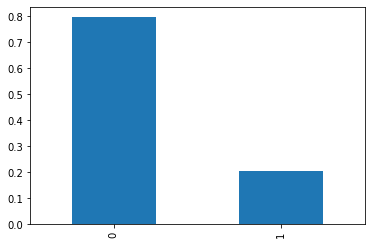

In [15]:
data['Exited'].value_counts(normalize=True).plot(kind='bar')

На диаграмме видна разница между количеством клиентов которые ушли из банка и нет - дисбаланс классов. Соотношение примерно 1/4.

In [16]:
print('Признаков имеющих значение 0 в выборке target_train:', target_train[target_train==0].shape[0])
print('Признаков имеющих значение 1 в выборке target_train:', target_train[target_train==1].shape[0])

Признаков имеющих значение 0 в выборке target_train: 4804
Признаков имеющих значение 1 в выборке target_train: 1196


В тренировочной выборке соблюдается то же соотношение 1/4

## Комментарий наставника
<span style="color:green">Именно так, дисбаланс явный.</span>

Создадим и обучим модель логистической регрессии без учёта несбалансированности классов:

In [17]:
model_no_balanced = LogisticRegression(solver='liblinear', random_state=12345)
model_no_balanced.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Создадим и обучим модель логистической регрессии с учётом несбалансированности классов:

In [18]:
model_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_balanced.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Попробуем увеличить выборку (техника **upsampling**):

Напишем функцию upsampling'а:

In [19]:
def upsample_positive(features, target, repeat):
    
    # разделим выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # выполним дублирование
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем данные
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Выполним **upsampling** и обучим модель логистической регрессии:

In [20]:
features_train_upsampled, target_train_upsampled = upsample_positive(features_train, target_train, 4)

model_upsampling = LogisticRegression(solver='liblinear', random_state=12345)
model_upsampling.fit(features_train_upsampled, target_train_upsampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Попробуем уменьшить выборку (техника **downsampling**):

Напишем функцию downsampling'а:

In [21]:
def downsample_negative(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Выполним **downsampling** и обучим модель логистической регрессии:

In [22]:
features_train_downsampled, target_train_downsampled = downsample_negative(features_train, target_train, 0.25)

model_downsampling = LogisticRegression(solver='liblinear', random_state=12345)
model_downsampling.fit(features_train_downsampled, target_train_downsampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Мы создали модели логистической регрессии без учёта дисбаланса классов, с учётом дисбаланса, на увеличенной и уменьшенной выборке. Теперь можно проверить эти модели. Сравним метрикой F1, а также построим PR-кривые для лучшего понимания.

In [23]:
print('Для модели логистической регрессии без учёта дисбаланса классов F1 = {:.2}'.format(
    f1_score(target_valid, model_no_balanced.predict(features_valid))))

print('Для модели логистической регрессии c учётом дисбаланса классов F1 = {:.2}'.format(
    f1_score(target_valid, model_balanced.predict(features_valid))))

print('Для модели логистической регрессии обученной на увеличенной выборке классов F1 = {:.2}'.format(
    f1_score(target_valid, model_upsampling.predict(features_valid))))

print('Для модели логистической регрессии обученной на уменьшенной выборке классов F1 = {:.2}'.format(
    f1_score(target_valid, model_downsampling.predict(features_valid))))

Для модели логистической регрессии без учёта дисбаланса классов F1 = 0.33
Для модели логистической регрессии c учётом дисбаланса классов F1 = 0.49
Для модели логистической регрессии обученной на увеличенной выборке классов F1 = 0.49
Для модели логистической регрессии обученной на уменьшенной выборке классов F1 = 0.48


Судя по метрике F1 наилучшие результаты показала модель, обученная с учётом дисбаланса классов. Модель без учёта дисбаланса классов и обученная на исходной выборке показала гораздо более плохие результаты. Модели, обученные на увеличенной и уменьшенной выборке показали результаты чуть хуже, чем модель, обученная, с учётом дисбаланса классов.

Построим PR кривые для визуального сравнения ошибок моделей:

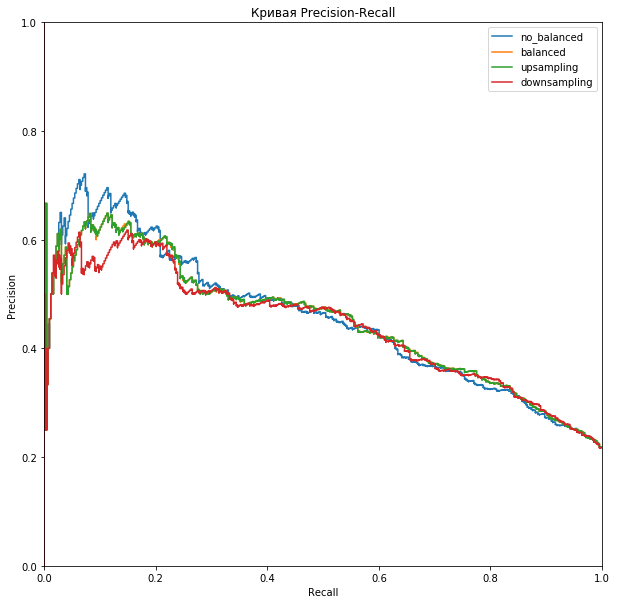

In [24]:
# получим вероятности классов для валидационной выборки для всех моделей
probabilities_no_balanced_valid = model_no_balanced.predict_proba(features_valid)
probabilities_balanced_valid = model_balanced.predict_proba(features_valid)
probabilities_upsampling_valid = model_upsampling.predict_proba(features_valid)
probabilities_downsampling_valid = model_downsampling.predict_proba(features_valid)

# получим точность и полноту для всех моделей
precision_no_balanced, recall_no_balanced, thresholds = precision_recall_curve(target_valid, probabilities_no_balanced_valid[:, 1])
precision_balanced, recall_balanced, thresholds = precision_recall_curve(target_valid, probabilities_balanced_valid[:, 1])
precision_upsampling, recall_upsampling, thresholds = precision_recall_curve(target_valid, probabilities_upsampling_valid[:, 1])
precision_downsampling, recall_downsampling, thresholds = precision_recall_curve(target_valid, probabilities_downsampling_valid[:, 1])

plt.figure(figsize=(10, 10))
plt.step(recall_no_balanced, precision_no_balanced, where='post')
plt.step(recall_balanced, precision_balanced, where='post')
plt.step(recall_upsampling, precision_upsampling, where='post')
plt.step(recall_downsampling, precision_downsampling, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.legend(['no_balanced', 'balanced', 'upsampling', 'downsampling'])
plt.show()

По графику видно, что при небольших значениях полноты, точность моделей без учёта несбалансированности превышает точность моделей обученных на изменённых размерах выборок. При увеличении полноты модель без учёта дисбаланса проигрывает остальным. <br>
Если бы задачей явлалась максимальная точность, лучше было бы использовать модель без учёта дисбаланса.

Оценим метрику AUC-ROC и сравним модели со случайной:

<Figure size 432x288 with 0 Axes>

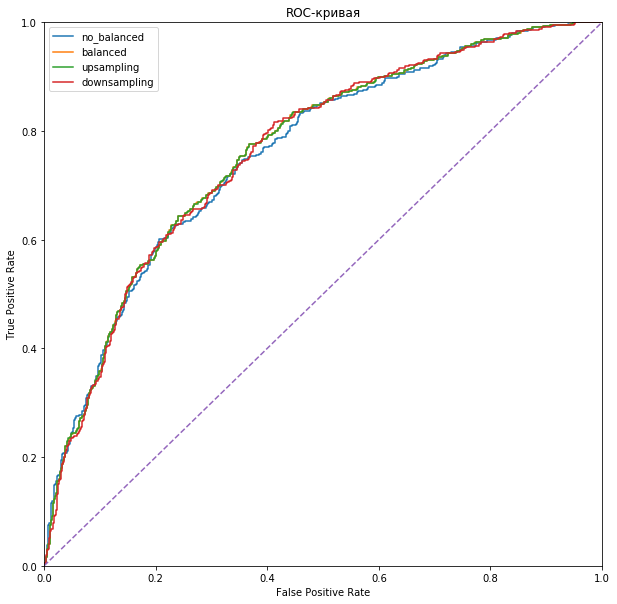

In [25]:
fpr_no_balanced, tpr_no_balanced, thresholds = roc_curve(target_valid, probabilities_no_balanced_valid[:, 1])
fpr_balanced, tpr_balanced, thresholds = roc_curve(target_valid, probabilities_balanced_valid[:, 1])
fpr_upsampling, tpr_upsampling, thresholds = roc_curve(target_valid, probabilities_upsampling_valid[:, 1])
fpr_downsampling, tpr_downsampling, thresholds = roc_curve(target_valid, probabilities_downsampling_valid[:, 1])

plt.figure()
plt.figure(figsize=(10, 10))
# графики моделей
plt.plot(fpr_no_balanced, tpr_no_balanced)
plt.plot(fpr_balanced, tpr_balanced)
plt.plot(fpr_upsampling, tpr_upsampling)
plt.plot(fpr_downsampling, tpr_downsampling)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend(['no_balanced', 'balanced', 'upsampling', 'downsampling'])
plt.show()

Все модели показали близкие результаты, лучшие чем у случайной модели.

Проведём аналогичное исследование для моделей случайного леса и определим, влияет ли модель на способ борьбы с дисбалансом.

Подберём гиперпараметры модели случайного леса на которой в дальнейшем исследуем способы борьбы с дисбалансом:

In [26]:
def RandomForestClassifier_optimize_f1(min_est, max_est, step_est, min_depth, max_depth, step_depth):
    f1 = 0
    depth_forest = 0
    estimators = 0

    for e in range(min_est, max_est, step_est):
        for d in range(min_depth, max_depth, step_depth):
            model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=e, max_depth=d)
            model_forest.fit(features_train, target_train)
            f1_current = f1_score(target_valid, model_forest.predict(features_valid))
            if f1_current > f1:
                f1 = f1_current
                depth_forest = d
                estimators = e
    return f1, estimators, depth_forest

In [27]:
%%time
f1_test, estimators_test, depth_forest_test = RandomForestClassifier_optimize_f1(min_est=10, max_est=100, step_est=2, min_depth=5, max_depth=17, step_depth=1)

CPU times: user 4min 9s, sys: 964 ms, total: 4min 10s
Wall time: 4min 11s


In [28]:

print('Лучший результат при проверке модели случайного леса с учётом дисбаланса получен: F1 = {:.3}, n_estimators = {:}, max_depth = {:}'
      .format(f1_test, estimators_test, depth_forest_test))

Лучший результат при проверке модели случайного леса с учётом дисбаланса получен: F1 = 0.638, n_estimators = 78, max_depth = 9


Посмотрим, какой результат покажет модель случайного леса с теми же гиперпараметрами, без учёта дисбаланса:

In [29]:
model_forest_no_balance = RandomForestClassifier(random_state=12345, n_estimators=71, max_depth=9)
model_forest_no_balance.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=71,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [30]:
print('Для модели случайного леса без учёта дисбаланса классов F1 = {:.2}'.format(
    f1_score(target_valid, model_forest_no_balance.predict(features_valid))))

Для модели случайного леса без учёта дисбаланса классов F1 = 0.56


Посмотрим, какой результат покажет модель случайного леса без учёта дисбаланса классов на увеличенной выборке:

In [31]:
model_forest_upsample = RandomForestClassifier(random_state=12345, n_estimators=71, max_depth=9)
model_forest_upsample.fit(features_train_upsampled, target_train_upsampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=71,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [32]:
print('Для модели случайного леса на увеличенной выборке F1 = {:.2}'.format(
    f1_score(target_valid, model_forest_upsample.predict(features_valid))))

Для модели случайного леса на увеличенной выборке F1 = 0.63


Посмотрим, какой результат покажет модель случайного леса без учёта дисбаланса классов на уменьшенной выборке:

In [33]:
model_forest_downsample = RandomForestClassifier(random_state=12345, n_estimators=71, max_depth=9)
model_forest_downsample.fit(features_train_downsampled, target_train_downsampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=71,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [34]:
print('Для модели случайного леса на уменьшенной выборке F1 = {:.2}'.format(
    f1_score(target_valid, model_forest_downsample.predict(features_valid))))

Для модели случайного леса на уменьшенной выборке F1 = 0.6


Построим PR кривые для визуального сравнения ошибок моделей:

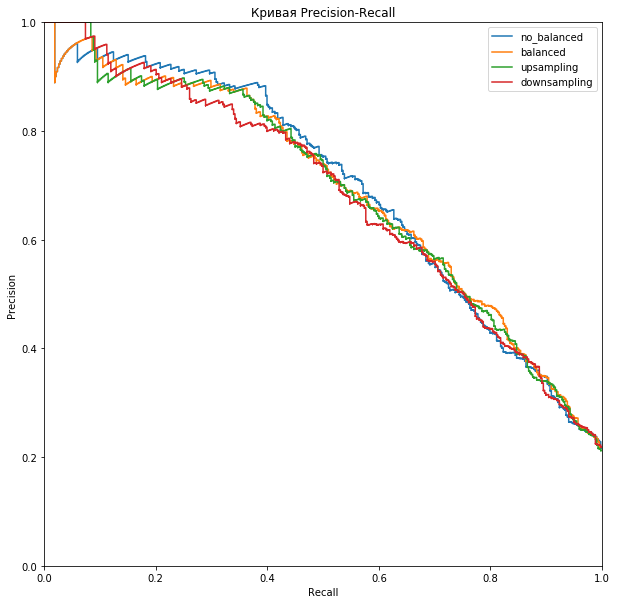

In [35]:
model_forest_balanced = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=71, max_depth=9)
model_forest_balanced.fit(features_train, target_train)

# получим вероятности классов для валидационной выборки для всех моделей
probabilities_forest_no_balanced_valid = model_forest_no_balance.predict_proba(features_valid)
probabilities_forest_balanced_valid = model_forest_balanced.predict_proba(features_valid)
probabilities_forest_upsampling_valid = model_forest_upsample.predict_proba(features_valid)
probabilities_forest_downsampling_valid = model_forest_downsample.predict_proba(features_valid)

# получим точность и полноту для всех моделей
precision_forest_no_balanced, recall_forest_no_balanced, thresholds = precision_recall_curve(target_valid, probabilities_forest_no_balanced_valid[:, 1])
precision_forest_balanced, recall_forest_balanced, thresholds = precision_recall_curve(target_valid, probabilities_forest_balanced_valid[:, 1])
precision_forest_upsampling, recall_forest_upsampling, thresholds = precision_recall_curve(target_valid, probabilities_forest_upsampling_valid[:, 1])
precision_forest_downsampling, recall_forest_downsampling, thresholds = precision_recall_curve(target_valid, probabilities_forest_downsampling_valid[:, 1])

plt.figure(figsize=(10, 10))
plt.step(recall_forest_no_balanced, precision_forest_no_balanced, where='post')
plt.step(recall_forest_balanced, precision_forest_balanced, where='post')
plt.step(recall_forest_upsampling, precision_forest_upsampling, where='post')
plt.step(recall_forest_downsampling, precision_forest_downsampling, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.legend(['no_balanced', 'balanced', 'upsampling', 'downsampling'])
plt.show()

Оценим метрику AUC-ROC и сравним модели со случайной:

<Figure size 432x288 with 0 Axes>

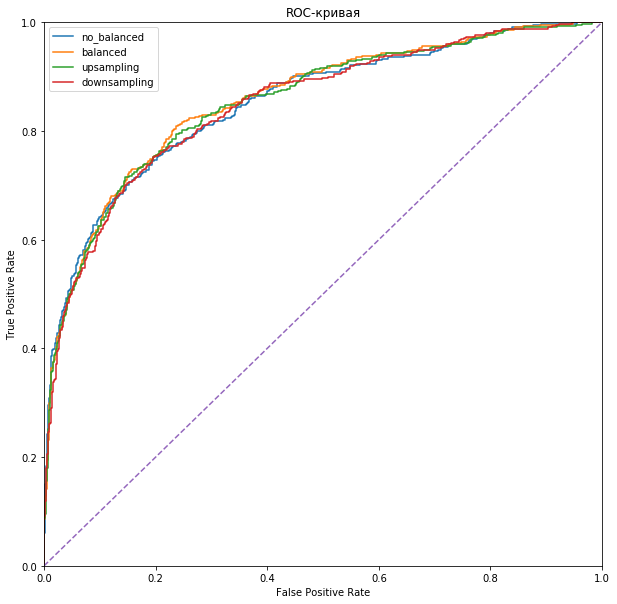

In [36]:
fpr_forest_no_balanced, tpr_forest_no_balanced, thresholds = roc_curve(target_valid, probabilities_forest_no_balanced_valid[:, 1])
fpr_forest_balanced, tpr_forest_balanced, thresholds = roc_curve(target_valid, probabilities_forest_balanced_valid[:, 1])
fpr_forest_upsampling, tpr_forest_upsampling, thresholds = roc_curve(target_valid, probabilities_forest_upsampling_valid[:, 1])
fpr_forest_downsampling, tpr_forest_downsampling, thresholds = roc_curve(target_valid, probabilities_forest_downsampling_valid[:, 1])

plt.figure()
plt.figure(figsize=(10, 10))
# графики моделей
plt.plot(fpr_forest_no_balanced, tpr_forest_no_balanced)
plt.plot(fpr_forest_balanced, tpr_forest_balanced)
plt.plot(fpr_forest_upsampling, tpr_forest_upsampling)
plt.plot(fpr_forest_downsampling, tpr_forest_downsampling)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend(['no_balanced', 'balanced', 'upsampling', 'downsampling'])
plt.show()

### Вывод:
По приведённым выше данным можно сделать вывод, что дисбаланс оказывает меньшее влияние на модель случайного леса, чем на модель логистической регрессии. Также видно, что модель случайного леса лучше логистической регрессии. <br>
Но борьба с дисбалансом всё же необходима, независимо от модели. <br>
Лучшие результаты показало взвешивание классов,чуть хуже upsampling, и downsampling. <br>
В дальнейшем для борьбы с дисбалансом воспользуемся взвешиванием классов, т.к. этот способ показал наилучшие результаты и для логистической регрессии и для случайного леса.

# 3. Борьба с дисбалансом

Исследуем и сравним модели логистической регрессии и случайного леса. В качестве способа борьбы с дисбалансом выберем взвешивание классов, как наиболее эффективный для этих моделей

Создадим и обучим модель логистической регрессии:

In [37]:
%%time
model_log_regress = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_log_regress.fit(features_train, target_train)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22.2 ms


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Для модели случайного леса будем использовать гиперпараметры полученные ранее:

In [38]:
%%time
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=71, max_depth=9)
model_forest.fit(features_train, target_train)

CPU times: user 552 ms, sys: 0 ns, total: 552 ms
Wall time: 577 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=71,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [39]:
print('Для логистической регрессии F1 = {:.2}, для случайного леса F1 = {:.2}'.format(
    f1_score(target_valid, model_log_regress.predict(features_valid)), 
    f1_score(target_valid, model_forest.predict(features_valid))))

Для логистической регрессии F1 = 0.49, для случайного леса F1 = 0.64


Видно, что модель случайного леса лучше логистической регрессии. Но также видно, что и на её обучение понадобилось гораздо больше времени.

Построим PR-кривые этих моделей и сравним наглядно:

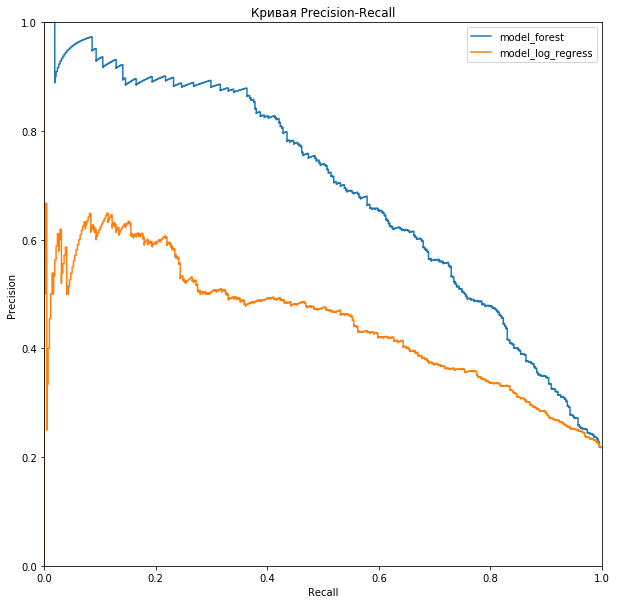

In [40]:
# получим вероятности классов для валидационной выборки для всех моделей
probabilities_forest_valid = model_forest.predict_proba(features_valid)
probabilities_log_regress_valid = model_log_regress.predict_proba(features_valid)

# получим точность и полноту для всех моделей
precision_forest_, recall_forest, thresholds = precision_recall_curve(target_valid, probabilities_forest_valid[:, 1])
precision_log_regress, recall_log_regress, thresholds = precision_recall_curve(target_valid, probabilities_log_regress_valid[:, 1])

plt.figure(figsize=(10, 10))
plt.step(recall_forest, precision_forest_, where='post')
plt.step(recall_log_regress, precision_log_regress, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.legend(['model_forest', 'model_log_regress'])
plt.show()

PR кривые показывают приемущество случайного леса. Во всём диапазоне значений полноты точность случайного леса всегда выше.

Для сравнения качества моделей построим ROC кривые:

<Figure size 432x288 with 0 Axes>

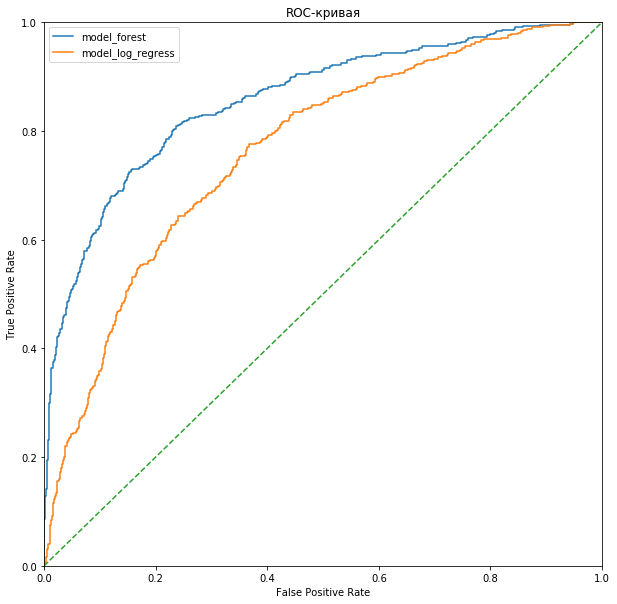

In [41]:
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, probabilities_forest_valid[:, 1])
fpr_log_regress, tpr_log_regress, thresholds = roc_curve(target_valid, probabilities_log_regress_valid[:, 1])

plt.figure()
plt.figure(figsize=(10, 10))
# графики моделей
plt.plot(fpr_forest, tpr_forest)
plt.plot(fpr_log_regress, tpr_log_regress)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend(['model_forest', 'model_log_regress'])
plt.show()

Судя по графикам, модель случайного леса лучше модели логистической регрессии, но обе модели предсказывают лучше, чем случайная модель

In [42]:
auc_roc_forest = roc_auc_score(target_valid, probabilities_forest_valid[:, 1])
auc_roc_log_regress = roc_auc_score(target_valid, probabilities_log_regress_valid[:, 1])

print('Для случайного леса AUC-ROC = {:.2}, для логистической регрессии AUC-ROC = {:.2}, для случайной модели AUC-ROC = 0.5'.
      format(auc_roc_forest, auc_roc_log_regress))

Для случайного леса AUC-ROC = 0.86, для логистической регрессии AUC-ROC = 0.76, для случайной модели AUC-ROC = 0.5


### Вывод:
В качестве финального варианта выберем модель случайного леса с гиперпараметрами n_estimators=71, max_depth=9. <br>
Она имеет F1=0.64, AUC-ROC=0.86 на тестовых данных.

## Комментарий наставника
<span style="color:green">Вот здесь уже и ROC-AUC есть, да ещё и с графиком. Молодец! Вывод верный.</span>

# 4. Тестирование модели

Проведём финальное обучение и тестирование выбранной модели на тестовой выборке:

In [43]:
%%time
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=71, max_depth=9)
model_forest.fit(features_train_valid, target_train_valid)

CPU times: user 700 ms, sys: 8 ms, total: 708 ms
Wall time: 709 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=71,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [44]:
print('F1 =', round(f1_score(target_test, model_forest.predict(features_test)),2))

F1 = 0.62


## Комментарий наставника
<span style="color:green">Достойная оценка по F1, класс! Кроме этого, правильно сделал, что совместил обучающую и валидационную выборки для финального тестирования. Чем больше данных для обучения, тем лучше.</span>

In [45]:
print('AUC-ROC =', round(roc_auc_score(target_test, model_forest.predict_proba(features_test)[:, 1]),2))

AUC-ROC = 0.86


Построим матрицу ошибок:

In [46]:
confusion_matrix(target_test, model_forest.predict(features_test))

array([[1380,  197],
       [ 145,  278]])

Ложноотрицательных и ложноположительных ответов примерно равное количество.

## Комментарий наставника
<span style="color:green">Окей.</span>

## Вывод: ##
В данном исследовании было изучено влияние дисбаланса классов на качество моделей, а также исследованы метрики R2, F1, AUC-ROC.<br>
- Дисбаланс классов приводит к значительному ухудшению моделей логистической регрессии и случайного леса.
- Дисбаланс классов имеет большее влияние на модель логистической регрессии
- Наиболее эффективным способом борьбы с дисбалансом для указанных моделей является взвешивание классов
- Upsampling и downsampling имеют примерно одинаковую эффективность (первый чуть более эффективен) <br><br>
В исследовании мы получили модель со значением F1-меры не менее 0.59 (0.62)

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*